In [1]:
#import libraries
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile

In [2]:
#extract the files from zip file
zipref = zipfile.ZipFile('archive.zip')
zipref.extractall()
zipref.close()

In [3]:
df = pd.read_csv('sp500_index.csv')
df.head()

,Date,S&P500
0,2013-09-30,1681.55
1,2013-10-01,1695.00
2,2013-10-02,1693.87
3,2013-10-03,1678.66
4,2013-10-04,1690.50


In [4]:
len(df)

2518

In [5]:
#convert to numpy array
data = df["S&P500"].values

#define a timeseries converting function
def create_train_and_test_datasets(DATA,TRAIN_MULTIPLIER,SEQUENCE_LENGTH,BATCH_SIZE = 128):

  """
  Creates tensorflow train and test datasets.
  Note: Test horizon is only 1.

  PARAMETERS
  ----------
  DATA: Sequential timeseries data without dates
  TRAIN_MULTIPLIER: Multiplier for train dataset
  SEQUENCE_LENGTH: Length of each input sequence
  BATCH_SIZE: Batch size
  """
  X = DATA[:-1] #fixed arrangements
  y = DATA[SEQUENCE_LENGTH:]
  dataset = tf.keras.utils.timeseries_dataset_from_array(data = X, targets=y,sequence_length = SEQUENCE_LENGTH,batch_size = None) #no batches first to count the number of instances
  dataset_size = tf.data.experimental.cardinality(dataset).numpy() #count the number of instances
  TRAIN_SIZE = int(TRAIN_MULTIPLIER*dataset_size)

  #create train and test datasets
  train_dataset = dataset.take(TRAIN_SIZE)
  test_dataset = dataset.skip(TRAIN_SIZE)

  #prep the datasets
  train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  return train_dataset,test_dataset

def define_callbacks(model):
  #es = tf.keras.callbacks.EarlyStopping(patience = 5,verbose = 1, restore_best_weights = True)
  mc = tf.keras.callbacks.ModelCheckpoint(filepath = f"./ModelCheckpoints/{model.name}.ckpt",
                                         save_best_only = True,
                                         save_weights_only = True)
 # tb = tf.keras.callbacks.TensorBoard(log_dir = f"./TensorboardLogs/{model.name}")

  return mc

In [6]:
#define global variables
TRAIN_MULTIPLIER = 0.8
SEQUENCE_LENGTH = 7

#create the datasets
train_dataset_7,test_dataset_7 = create_train_and_test_datasets(DATA = data,
                                                            TRAIN_MULTIPLIER=TRAIN_MULTIPLIER,
                                                            SEQUENCE_LENGTH = SEQUENCE_LENGTH)

In [7]:
train_dataset_7,test_dataset_7

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [8]:
LOSS = 'mae'
MODEL_NAME ='model1'

#create the baseline model
model = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,-1)),
    layers.LSTM(16,return_sequences = False),
    layers.Dense(1,activation = 'linear')
],name = MODEL_NAME)

#compile the model
model.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)
#define model checkpoint
mc = define_callbacks(model)

#fit the model
history = model.fit(train_dataset_7,
                    validation_data = test_dataset_7,
                    epochs = 100,
                    verbose = 0
                    callbacks = [mc])

Epoch 1/100
16/16 [==============================] - 16s 156ms/step - loss: 2622.9521 - mae: 2622.9521 - val_loss: 4208.8799 - val_mae: 4208.8799
Epoch 2/100
16/16 [==============================] - 1s 78ms/step - loss: 2622.8955 - mae: 2622.8955 - val_loss: 4208.8232 - val_mae: 4208.8232
Epoch 3/100
16/16 [==============================] - 2s 110ms/step - loss: 2622.8391 - mae: 2622.8391 - val_loss: 4208.7666 - val_mae: 4208.7666
Epoch 4/100
16/16 [==============================] - 1s 37ms/step - loss: 2622.7830 - mae: 2622.7830 - val_loss: 4208.7104 - val_mae: 4208.7104
Epoch 5/100
16/16 [==============================] - 1s 37ms/step - loss: 2622.7266 - mae: 2622.7266 - val_loss: 4208.6543 - val_mae: 4208.6543
Epoch 6/100
16/16 [==============================] - 1s 38ms/step - loss: 2622.6699 - mae: 2622.6699 - val_loss: 4208.5977 - val_mae: 4208.5977
Epoch 7/100
16/16 [==============================] - 1s 36ms/step - loss: 2622.6135 - mae: 2622.6135 - val_loss: 4208.5405 - val_mae:

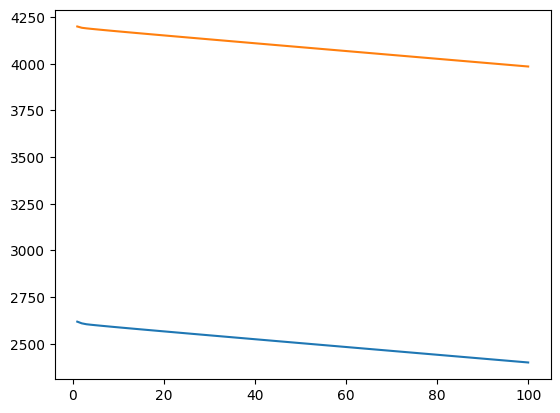

In [20]:
val_mae = history3.history['val_mae']
mae = history3.history['mae']
epochs = range(1,101)

plt.figure()
plt.plot(epochs,mae)
plt.plot(epochs,val_mae)

In [11]:
#load the best model
best_model = tf.keras.models.clone_model(model)

#load the weights
best_model.load_weights("./ModelCheckpoints/model1.ckpt")

#compile the new model
best_model.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)

best_model.evaluate(test_dataset_7)

4/4 [==============================] - 1s 13ms/step - loss: 4203.2988 - mae: 4203.2988


[4203.298828125, 4203.298828125]

In [13]:
#model2: increase the lstm neurons

LOSS = 'mae'
MODEL_NAME ='model2'

#create the baseline model
model2 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,-1)),
    layers.LSTM(128,return_sequences = False),
    layers.Dense(1,activation = 'linear')
],name = MODEL_NAME)

#compile the model
model2.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)
#define model checkpoint
mc = define_callbacks(model2)

#fit the model
history2 = model2.fit(train_dataset_7,
                    validation_data = test_dataset_7,
                    epochs = 100,
                    verbose = 0,
                    callbacks = [mc])

In [15]:
#load the best model
best_model2 = tf.keras.models.clone_model(model2)

#load the weights
best_model2.load_weights("./ModelCheckpoints/model2.ckpt")

#compile the new model
best_model2.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)

best_model2.evaluate(test_dataset_7)

4/4 [==============================] - 1s 15ms/step - loss: 4165.1309 - mae: 4165.1309


[4165.130859375, 4165.130859375]

In [18]:
#model3: increase lstm lyaers

LOSS = 'mae'
MODEL_NAME ='model3'

#create the baseline model
model3 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,-1)),
    layers.LSTM(128,return_sequences = True),
    layers.LSTM(128, return_sequences = False),
    layers.Dense(1,activation = 'linear')
],name = MODEL_NAME)

#compile the model
model3.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)
#define model checkpoint
mc = define_callbacks(model3)

#fit the model
history3 = model3.fit(train_dataset_7,
                    validation_data = test_dataset_7,
                    epochs = 100,
                    verbose = 0,
                    callbacks = [mc])

In [24]:
#load the best model
best_model3 = tf.keras.models.clone_model(model3)

#load the weights
best_model3.load_weights("./ModelCheckpoints/model3.ckpt")

#compile the new model
best_model3.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)

best_model3.evaluate(test_dataset_7)

4/4 [==============================] - 2s 13ms/step - loss: 3984.9417 - mae: 3984.9417


[3984.941650390625, 3984.941650390625]

In [25]:
#model4 add a dense

LOSS = 'mae'
MODEL_NAME ='model4'

#create the baseline model
model4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,-1)),
    layers.LSTM(128,return_sequences = True),
    layers.LSTM(128,return_sequences = False),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(1,activation = 'linear')
],name = MODEL_NAME)

#compile the model
model4.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)
#define model checkpoint
mc = define_callbacks(model4)

#fit the model
history4 = model4.fit(train_dataset_7,
                    validation_data = test_dataset_7,
                    epochs = 100,
                    verbose = 0,
                    callbacks = [mc])

In [26]:
#load the best model
best_model4 = tf.keras.models.clone_model(model4)

#load the weights
best_model4.load_weights("./ModelCheckpoints/model4.ckpt")

#compile the new model
best_model4.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)

best_model4.evaluate(test_dataset_7)

4/4 [==============================] - 1s 12ms/step - loss: 1690.2316 - mae: 1690.2316


[1690.2315673828125, 1690.2315673828125]

In [28]:
#model5: add a Conv1D layer
LOSS = 'mae'
MODEL_NAME ='model5'

#create the baseline model
model5 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,-1)),
    layers.Conv1D(filters = 64,kernel_size = 3,activation = 'relu'),
    layers.LSTM(128,return_sequences = True),
    layers.LSTM(128,return_sequences = False),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(1,activation = 'linear')
],name = MODEL_NAME)

#compile the model
model5.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)
#define model checkpoint
mc = define_callbacks(model5)

#fit the model
history5 = model5.fit(train_dataset_7,
                    validation_data = test_dataset_7,
                    epochs = 100,
                    verbose = 0,
                    callbacks = [mc])

In [30]:
#load the best model
best_model5 = tf.keras.models.clone_model(model5)

#load the weights
best_model5.load_weights("./ModelCheckpoints/model5.ckpt")

#compile the new model
best_model5.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)

best_model5.evaluate(test_dataset_7)

4/4 [==============================] - 2s 12ms/step - loss: 1690.2577 - mae: 1690.2577


[1690.2576904296875, 1690.2576904296875]

In [31]:
#model6: change the horizon

train_dataset_5,test_dataset_5 = create_train_and_test_datasets(data,0.8,5)

LOSS = 'mae'
MODEL_NAME ='model6'

#create the baseline model
model6 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,-1)),
    layers.LSTM(128,return_sequences = True),
    layers.LSTM(128,return_sequences = False),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(1,activation = 'linear')
],name = MODEL_NAME)

#compile the model
model6.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)
#define model checkpoint
mc = define_callbacks(model6)

#fit the model
history6 = model6.fit(train_dataset_5,
                    validation_data = test_dataset_5,
                    epochs = 100,
                    verbose = 0,
                    callbacks = [mc])


In [34]:
#load the best model
best_model6 = tf.keras.models.clone_model(model6)

#load the weights
best_model6.load_weights("./ModelCheckpoints/model6.ckpt")

#compile the new model
best_model6.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)

best_model6.evaluate(test_dataset_7)

4/4 [==============================] - 2s 16ms/step - loss: 1692.9987 - mae: 1693.4987


[1692.9986572265625, 1693.4986572265625]

In [33]:
#change the loss

LOSS = 'huber'
MODEL_NAME ='model7'

#create the baseline model
model7 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,-1)),
    layers.LSTM(128,return_sequences = True),
    layers.LSTM(128,return_sequences = False),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(1,activation = 'linear')
],name = MODEL_NAME)

#compile the model
model7.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)

#define model checkpoint
mc = define_callbacks(model7)

#fit the model
history7 = model7.fit(train_dataset_7,
                    validation_data = test_dataset_7,
                    epochs = 100,
                    verbose = 0,
                    callbacks = [mc])

In [35]:
#load the best model
best_model7 = tf.keras.models.clone_model(model7)

#load the weights
best_model7.load_weights("./ModelCheckpoints/model7.ckpt")

#compile the new model
best_model7.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)

best_model7.evaluate(test_dataset_7)

4/4 [==============================] - 2s 17ms/step - loss: 1689.7123 - mae: 1690.2123


[1689.7122802734375, 1690.2122802734375]

In [37]:
tf.keras.backend.clear_session()

In [38]:
#change the loss mse

LOSS = 'mse'
MODEL_NAME ='model8'

#create the baseline model
model8 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,-1)),
    layers.LSTM(128,return_sequences = True),
    layers.LSTM(128,return_sequences = False),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(1,activation = 'linear')
],name = MODEL_NAME)

#compile the model
model8.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)

#define model checkpoint
mc = define_callbacks(model8)

#fit the model
history8 = model8.fit(train_dataset_7,
                    validation_data = test_dataset_7,
                    epochs = 100,
                    verbose = 0,
                    callbacks = [mc])

In [39]:
#load the best model
best_model8 = tf.keras.models.clone_model(model8)

#load the weights
best_model8.load_weights("./ModelCheckpoints/model8.ckpt")

#compile the new model
best_model8.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)

best_model8.evaluate(test_dataset_7)

4/4 [==============================] - 2s 13ms/step - loss: 2494463.5000 - mae: 1551.7977


[2494463.5, 1551.7977294921875]

In [40]:
#change the loss mape

LOSS = 'mape'
MODEL_NAME ='model9'

#create the baseline model
model9 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,-1)),
    layers.LSTM(128,return_sequences = True),
    layers.LSTM(128,return_sequences = False),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(1,activation = 'linear')
],name = MODEL_NAME)

#compile the model
model9.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)

#define model checkpoint
mc = define_callbacks(model9)

#fit the model
history9 = model9.fit(train_dataset_7,
                    validation_data = test_dataset_7,
                    epochs = 100,
                    verbose = 0,
                    callbacks = [mc])

In [42]:
#load the best model
best_model9 = tf.keras.models.clone_model(model9)

#load the weights
best_model9.load_weights("./ModelCheckpoints/model9.ckpt")

#compile the new model
best_model9.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)

best_model9.evaluate(test_dataset_7)

4/4 [==============================] - 2s 13ms/step - loss: 45.6695 - mae: 1933.4944


[45.66946029663086, 1933.494384765625]

In [43]:
#arrange the learning rate
LOSS = 'mse'
MODEL_NAME ='model10'

#create the baseline model
model10 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,-1)),
    layers.LSTM(128,return_sequences = True),
    layers.LSTM(128,return_sequences = False),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(1,activation = 'linear')
],name = MODEL_NAME)

#compile the model
model10.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)

#define model checkpoint
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

#fit the model
history10 = model10.fit(train_dataset_7,
                    validation_data = test_dataset_7,
                    epochs = 100,
                    verbose = 0,
                    callbacks = [lr_schedule])

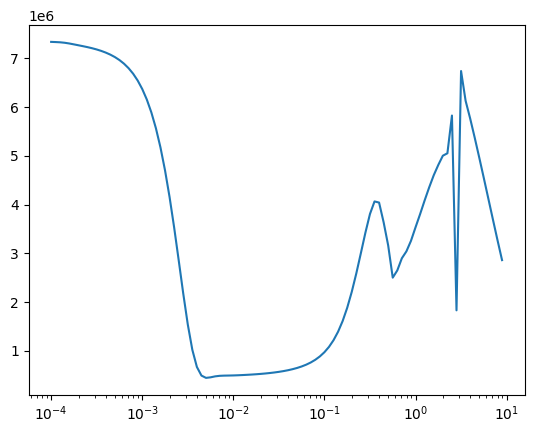

In [45]:
plt.semilogx(history10.history['lr'],history10.history['loss'])

In [47]:
#change it to optimal learning rate
#arrange the learning rate
LOSS = 'mse'
MODEL_NAME ='model10'

#create the baseline model
model10 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,-1)),
    layers.LSTM(128,return_sequences = True),
    layers.LSTM(128,return_sequences = False),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(1,activation = 'linear')
],name = MODEL_NAME)

#compile the model
model10.compile(
    optimizer = tf.keras.optimizers.Adam(5e-3),
    loss = LOSS,
    metrics = 'mae'
)

#define model checkpoint
mc = define_callbacks(model10)

#fit the model
history10 = model10.fit(train_dataset_7,
                    validation_data = test_dataset_7,
                    epochs = 100,
                    verbose = 0,
                    callbacks = [mc])

In [49]:
#load the best model
best_model10 = tf.keras.models.clone_model(model10)

#load the weights
best_model10.load_weights("./ModelCheckpoints/model10.ckpt")

#compile the new model
best_model10.compile(
    optimizer = 'adam',
    loss = LOSS,
    metrics = 'mae'
)

best_model10.evaluate(test_dataset_7)

4/4 [==============================] - 1s 12ms/step - loss: 2472165.2500 - mae: 1544.5963


[2472165.25, 1544.5963134765625]

In [50]:
best_model.save('best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
